## Data Wrangling

#### Standard Imports

In [1]:
#Necessary Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format #Turning off scientific notations
import sweetviz

In [2]:
# Text Analysis related imports
import nltk 
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud, STOPWORDS 

In [103]:
# Model building Imports
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeRegressor

from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

E:\Python\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


#### Data Ingestion

In [4]:
#Data Ingestion
os.chdir("E:/Springboard/Capstone 2/data sets")
df=pd.read_csv("zomato_restaurants_in_india.csv")
print(df.shape)
df.head(1).T

(211944, 26)


,0
res_id,3400299
name,Bikanervala
establishment,['Quick Bites']
url,https://www.zomato.com/agra/bikanervala-khanda...
address,"Kalyani Point, Near Tulsi Cinema, Bypass Road,..."
city,Agra
city_id,34
locality,Khandari
latitude,27.21
longitude,78.00


#### Checking EDA Report through Sweetviz Package on the whole data

In [5]:
report = sweetviz.analyze(df)
report.show_html('full_data.html')

:FEATURES DONE:                    |█████████████████████| [100%]   00:23  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:36  -> (00:00 left)


Creating Associations graph... DONE!
Report full_data.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


#### Check for duplicates

In [44]:
df.duplicated().sum() 

151527

In [45]:
df['res_id'].duplicated().sum()

156376

In [46]:
df=df.drop_duplicates(subset='res_id') 
#Dropped duplicates on the basis of res_id as res_id is unique for every restaurant and for each branch, after this zipcode will be removed
df.shape

(55568, 26)

#### Missing value treatment

In [47]:
(df.isnull().sum() / len(df)).sort_values(ascending=False)

zipcode                0.80
aggregate_rating       0.18
timings                0.02
average_cost_for_two   0.01
cuisines               0.01
address                0.00
opentable_support      0.00
takeaway               0.00
longitude              0.00
name                   0.00
establishment          0.00
url                    0.00
city                   0.00
city_id                0.00
locality               0.00
latitude               0.00
locality_verbose       0.00
country_id             0.00
delivery               0.00
price_range            0.00
currency               0.00
highlights             0.00
rating_text            0.00
votes                  0.00
photo_count            0.00
res_id                 0.00
dtype: float64

In [48]:
# Zip Code, has to be dropped as 80% values are missing and it is not much of a contributor to the analysis.
# Locality can very well be used inplace of Zip Code.

# Also, res_id now is just an identifier, and isn't of much use, so dropping this as well.

# country_id is redundant as all restaurants pertain to India only, so dropping it.

# url isn't much help here either, customers will order from Zomato, and Zomato already has all info, so dropping it.

# Address and locality have extra info which isn't required as such because locality_verbose variable is here.

# Dropping city_id, city name is available here

# Currency field has to go, currency is INR only!

# opentable_support has all 0 values, so this should be dropped too

In [49]:
df=df.drop(['res_id','url','country_id','currency', 'address', 'locality','city_id', 'zipcode', 'opentable_support'],axis=1)

In [50]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,55568,41100,Domino's Pizza,399,NaN,NaN,NaN,NaN,NaN,NaN,NaN
establishment,55568,27,['Quick Bites'],14032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,55568,99,Bangalore,2247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,55568.00,NaN,NaN,NaN,21.45,42.90,0.00,16.52,22.47,26.75,10000.00
longitude,55568.00,NaN,NaN,NaN,76.50,10.98,0.00,74.65,77.11,79.83,91.83
locality_verbose,55568,3910,"Gomti Nagar, Lucknow",274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cuisines,55098,9382,North Indian,4295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timings,54565,7740,11 AM to 11 PM,7012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_cost_for_two,54748.00,NaN,NaN,NaN,536.12,595.92,2.00,200.00,350.00,600.00,30000.00
price_range,55568.00,NaN,NaN,NaN,1.71,0.88,1.00,1.00,1.00,2.00,4.00


#### Data Prep : Fixing Incorrect Data Types

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55568 entries, 0 to 211942
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  55568 non-null  object 
 1   establishment         55568 non-null  object 
 2   city                  55568 non-null  object 
 3   latitude              55568 non-null  float64
 4   longitude             55568 non-null  float64
 5   locality_verbose      55568 non-null  object 
 6   cuisines              55098 non-null  object 
 7   timings               54565 non-null  object 
 8   average_cost_for_two  54748 non-null  float64
 9   price_range           55568 non-null  int64  
 10  highlights            55568 non-null  object 
 11  aggregate_rating      45510 non-null  float64
 12  rating_text           55568 non-null  object 
 13  votes                 55568 non-null  int64  
 14  photo_count           55568 non-null  int64  
 15  delivery          

In [52]:
#delivery, takeaway and price_range columns are categorical and are stored as int, so this needs to be fixed.
df['delivery'] = df['delivery'].astype(object)
df['takeaway'] = df['takeaway'].astype(object)
df['price_range'] = df['price_range'].astype(object)

In [53]:
df['delivery'].value_counts(dropna=False)

-1    37346
 1    17907
 0      315
Name: delivery, dtype: int64

In [54]:
df['takeaway'].value_counts(dropna=False)

-1    55568
Name: takeaway, dtype: int64

In [55]:
# Assuming -1 is a data entry error, so -1 is to be encoded as 1 for both delivery and takeaway

df['delivery'] = df['delivery'].replace(-1, 1)

In [56]:
df['takeaway'] = df['takeaway'].replace(-1,1)

In [57]:
print(df['delivery'].value_counts(normalize=True)) #99% offer delivery, 1% don't
print('*****************************************')
print(df['takeaway'].value_counts(normalize=True)) #100% offer takeaway

1   0.99
0   0.01
Name: delivery, dtype: float64
*****************************************
1   1.00
Name: takeaway, dtype: float64


#### Checking correlations

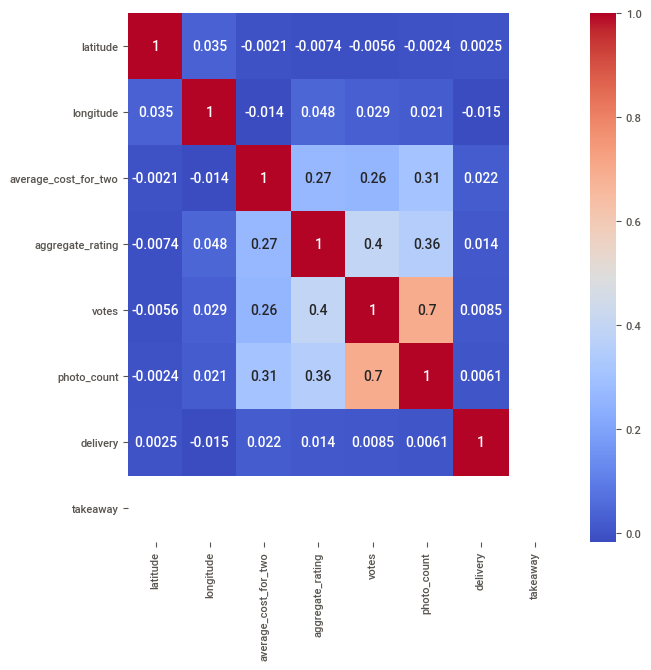

In [58]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.show()

In [59]:
# Photo_count and votes are highly correlated
# Rest all seem to be in acceptable range

#### Visualising the Dependent Variable (Aggregate Rating)

In [64]:
df['aggregate_rating'].describe()

count   45510.00
mean        3.61
std         0.51
min         1.80
25%         3.30
50%         3.70
75%         4.00
max         4.90
Name: aggregate_rating, dtype: float64

In [65]:
df['aggregate_rating'] = df['aggregate_rating'].replace(0, np.nan)
df['average_cost_for_two'] = df['average_cost_for_two'].replace(0, np.nan)

In [66]:
df[df['aggregate_rating'] == 0]

,name,establishment,city,latitude,longitude,locality_verbose,cuisines,timings,average_cost_for_two,price_range,highlights,aggregate_rating,rating_text,votes,photo_count,delivery,takeaway


In [67]:
# Extracting Not Null values only
df_nn = df[pd.notnull(df['aggregate_rating'])]

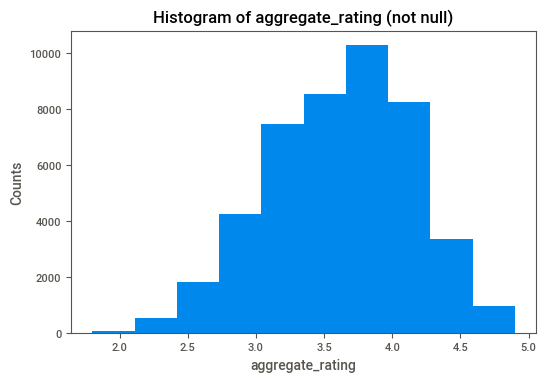

In [69]:
plt.hist(df_nn['aggregate_rating'])
plt.title('Histogram of aggregate_rating (not null)')
plt.xlabel('aggregate_rating')
plt.ylabel('Counts')
plt.show()

In [23]:
# Zomato has a rating scale of 1-5 only, so restaurants rated 0 seem incorrect.
# 0 is missing value here (could be unrated as rating_text for these values says not rated)

In [95]:
# Imputing missing values for average_cost_for_two
df_nn['average_cost_for_two'].fillna(df_nn['average_cost_for_two'].median(), inplace=True)

E:\Python\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


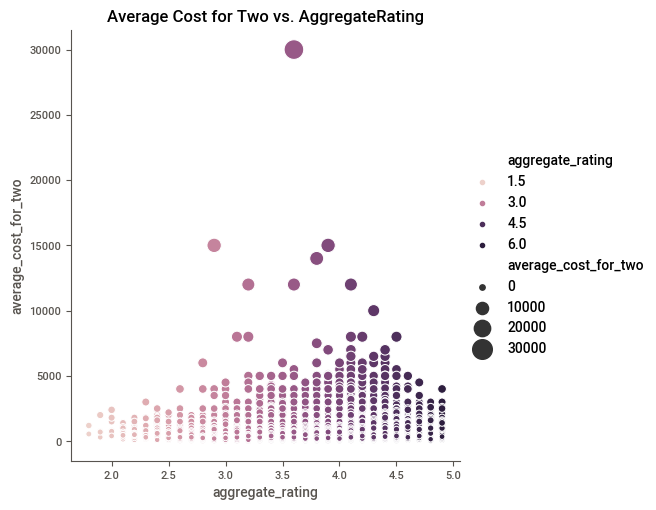

In [70]:
sns.relplot(y = 'average_cost_for_two', x = 'aggregate_rating', size='average_cost_for_two', hue = 'aggregate_rating',
            sizes= (15,200), data = df_nn)
plt.title("Average Cost for Two vs. AggregateRating")

plt.show()

In [6]:
# # Checking Sweetviz report again on this trimmed and cleaned version of the data

report_trim = sweetviz.analyze(df)
report_trim.show_html('data_trim.html')

:FEATURES DONE:                    |█████████████████████| [100%]   00:39  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:57  -> (00:00 left)


Creating Associations graph... DONE!
Report data_trim.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


#### Exploring the text columns

In [71]:
# Establishment
df_nn.establishment[0].replace('[','').replace(']','').replace("'",'')

df_nn.establishment=df_nn.establishment.apply(lambda x:x.replace('[','').replace(']','').replace("'",''))

E:\Python\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [72]:
est_wc = ' '.join(df_nn['establishment'])

Word Cloud of Establishment!!


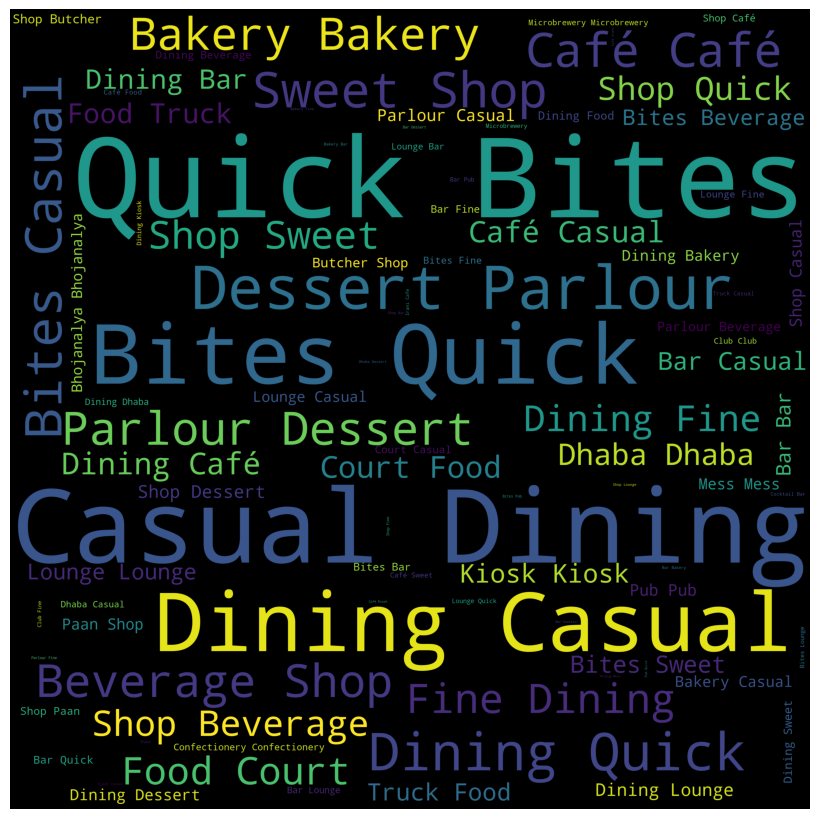

In [73]:
# Word Cloud 
wordcloud = WordCloud(width = 3000, height = 3000, 
                background_color ='black', 
                min_font_size = 10, random_state=100).generate(est_wc) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")
plt.xlabel('Word Cloud')
plt.tight_layout(pad = 0) 

print("Word Cloud of Establishment!!")
plt.show()

In [74]:
df_nn['establishment'].value_counts(dropna=False).head()

Quick Bites        11955
Casual Dining      10754
Café                3574
Dessert Parlour     3090
Bakery              2734
Name: establishment, dtype: int64

In [31]:
# Quick Bites, Casual Dining, Cafe are the dominant establishment types

In [75]:
# Highlights
df_nn.highlights[0].replace('[','').replace(']','').replace("'",'')

df_nn.highlights=df_nn.highlights.apply(lambda x:x.replace('[','').replace(']','').replace("'",''))

In [76]:
df_nn['highlights'].value_counts().head()

Dinner, Takeaway Available, Lunch, Cash, Indoor Seating                                                        617
Dinner, Delivery, Lunch, Cash, Takeaway Available, Indoor Seating                                              487
                                                                                                               260
Cash, Takeaway Available                                                                                       219
Dinner, Cash, Takeaway Available, Debit Card, Lunch, Delivery, Credit Card, Indoor Seating, Air Conditioned    205
Name: highlights, dtype: int64

In [77]:
# Since I want to do some analysis on the highlights vs ratings,
# it is better tosplit the values of each record to extract different words, 
# Else, the whole data frame will become really cluttered
subset = df_nn[['highlights', 'aggregate_rating']]

In [78]:
high_split = subset['highlights'].str.get_dummies(sep = ",")

high_split

,4/5 Star,Above 18 Only,Air Conditioned,Alipay Accepted,All Day Breakfast,Available for Functions,Axis Bank - Dining Delights,BYOB,Beer,Bira 91 Beer,...,Outdoor Seating,Poolside,Pure Veg,Rooftop,Self Service,Serves Alcohol,Standing Tables,Table Reservation Not Required,Takeaway Available,Wifi
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211882,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211925,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211926,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211940,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
subset = pd.concat([subset, high_split], axis=1).drop('highlights', axis = 1)
subset

,aggregate_rating,4/5 Star,Above 18 Only,Air Conditioned,Alipay Accepted,All Day Breakfast,Available for Functions,Axis Bank - Dining Delights,BYOB,Beer,...,Outdoor Seating,Poolside,Pure Veg,Rooftop,Self Service,Serves Alcohol,Standing Tables,Table Reservation Not Required,Takeaway Available,Wifi
0,4.40,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.20,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.30,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4.90,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211882,2.90,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211925,4.00,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211926,3.90,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211940,4.10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
subset.columns

Index(['aggregate_rating', ' 4/5 Star', ' Above 18 Only', ' Air Conditioned',
       ' Alipay Accepted', ' All Day Breakfast', ' Available for Functions',
       ' Axis Bank - Dining Delights', ' BYOB', ' Beer',
       ...
       'Outdoor Seating', 'Poolside', 'Pure Veg', 'Rooftop', 'Self Service',
       'Serves Alcohol', 'Standing Tables', 'Table Reservation Not Required',
       'Takeaway Available', 'Wifi'],
      dtype='object', length=132)

In [81]:
# Declare an explanatory variable, called X,and assign it the result of dropping 'Name' and 'AdultWeekend' from the df
X = subset.drop(['aggregate_rating'], axis=1)

# Declare a response variable, called y, and assign it the AdultWeekend column of the df 
y = subset['aggregate_rating'] 

# Here we use the StandardScaler() method of the preprocessing package, and then call the fit() method with parameter X 
scaler = preprocessing.StandardScaler().fit(X)

# Declare a variable called X_scaled, and assign it the result of calling the transform() method with parameter X 
X_scaled=scaler.transform(X)

In [82]:
y = y.ravel()

In [83]:
gini_model = tree.DecisionTreeRegressor(criterion = 'mse', random_state=5)

gini_model.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=5, splitter='best')

In [84]:
feature_imp=pd.Series(gini_model.feature_importances_,index=X.columns)
a = feature_imp.sort_values(ascending=False).head(20)
a

 Table booking recommended        0.11
 Credit Card                      0.06
 Digital Payments Accepted        0.04
 Outdoor Seating                  0.03
 Breakfast                        0.03
 Takeaway Available               0.03
 Pure Veg                         0.03
 Air Conditioned                  0.03
 Free Parking                     0.03
 Lunch                            0.02
 Indoor Seating                   0.02
 No Alcohol Available             0.02
 Debit Card                       0.02
 Table Reservation Not Required   0.02
 Dinner                           0.02
 Valet Parking Available          0.02
 Desserts and Bakes               0.02
 Mall Parking                     0.02
 Delivery                         0.02
 Wifi                             0.02
dtype: float64

In [43]:
# Table booking recommended, Credit Card, Digital Payments Accepted, Outdoor seating, etc are the top highlights
# affecting Ratings (out of all highlights)

#### Checking if cuisine has an effect on rating 

In [44]:
subset2 = df_nn[['cuisines', 'aggregate_rating']]

In [45]:
cuisines = subset2['cuisines'].str.get_dummies(sep = ',')
cuisines

,Afghan,Afghani,African,American,Andhra,Arabian,Armenian,Asian,Assamese,Awadhi,...,Street Food,Sushi,Tamil,Tea,Tex-Mex,Thai,Tibetan,Turkish,Vietnamese,Wraps
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211882,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211925,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211940,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
subset2 = pd.concat([subset2, cuisines], axis=1).drop('cuisines', axis = 1)
subset2

,aggregate_rating,Afghan,Afghani,African,American,Andhra,Arabian,Armenian,Asian,Assamese,...,Street Food,Sushi,Tamil,Tea,Tex-Mex,Thai,Tibetan,Turkish,Vietnamese,Wraps
0,4.40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.90,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211882,2.90,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211925,4.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211926,3.90,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211940,4.10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
#Declare an explanatory variable, called X,and assign it the result of dropping 'aggregate_rating' from the df
X2 = subset2.drop(['aggregate_rating'], axis=1)

# Declare a response variable, called y, and assign it the aggregate_rating column of the df 
y2 = subset2['aggregate_rating'] 

# Here we use the StandardScaler() method of the preprocessing package, and then call the fit() method with parameter X 
scaler2 = preprocessing.StandardScaler().fit(X2)


In [52]:
# Declare a variable called X_scaled, and assign it the result of calling the transform() method with parameter X 
X_scaled2=scaler2.transform(X2)

y2 = y2.ravel()

In [53]:
dt2 = tree.DecisionTreeRegressor(criterion = 'mse', random_state=5)

dt2.fit(X2, y2)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=5, splitter='best')

In [54]:
feature_imp=pd.Series(dt2.feature_importances_,index=X2.columns)
b = feature_imp.sort_values(ascending=False).head(20)
b

 Italian         0.08
 Asian           0.05
 Chinese         0.04
 Fast Food       0.03
 Continental     0.03
 Desserts        0.03
 North Indian    0.02
 Mediterranean   0.02
 Mughlai         0.02
 Beverages       0.02
Asian            0.02
North Indian     0.02
 Biryani         0.02
 Sandwich        0.02
 South Indian    0.02
 Burger          0.02
 Cafe            0.02
 Pizza           0.02
Continental      0.01
Burger           0.01
dtype: float64

In [ ]:
# Italian, Asian, Chinese are better rated

#### Developing train test datasets

In [97]:
df_nn.columns # Using the subset without NULL Values for Aggregate_Rating

Index(['name', 'establishment', 'city', 'latitude', 'longitude',
       'locality_verbose', 'cuisines', 'timings', 'average_cost_for_two',
       'price_range', 'highlights', 'aggregate_rating', 'rating_text', 'votes',
       'photo_count', 'delivery', 'takeaway'],
      dtype='object')

In [98]:
X = df_nn.drop(['aggregate_rating', 'name', 'establishment', 'locality_verbose', 'cuisines', 'timings', 'highlights',
               'rating_text'], axis=1)
y = df_nn['aggregate_rating']

In [99]:
X = pd.get_dummies(X)
X

,latitude,longitude,average_cost_for_two,votes,photo_count,delivery,takeaway,city_Agra,city_Ahmedabad,city_Ajmer,...,city_Vadodara,city_Varanasi,city_Vellore,city_Vijayawada,city_Vizag,city_Zirakpur,price_range_1,price_range_2,price_range_3,price_range_4
0,27.21,78.00,700.00,814,154,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,27.16,78.01,600.00,1203,161,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,27.18,77.98,300.00,801,107,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,27.21,78.00,300.00,693,157,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,27.16,78.05,1000.00,470,291,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211882,22.27,73.20,200.00,4,1,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
211925,22.31,73.17,700.00,111,38,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
211926,22.32,73.17,250.00,207,14,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
211940,22.32,73.20,300.00,187,40,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

<IPython.core.display.Javascript object>

In [101]:
dt_model = tree.DecisionTreeRegressor(criterion = 'mse', random_state=5)

dt_model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=5, splitter='best')

In [ ]:
# dot_data = StringIO()

# # We can do so with export_graphviz
# tree.export_graphviz(dt_model, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names=X_train.columns) 


# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [109]:
y_pred_dt = dt_model.predict(X_test)

y_pred_dt = pd.Series(y_pred_dt)

from sklearn.model_selection import cross_val_score

cross_val_score(dt_model, X_test, y_test, cv=10)


array([0.24146553, 0.24915015, 0.2299836 , 0.20005613, 0.19833668,
       0.21924522, 0.09266969, 0.19756167, 0.30208316, 0.23582258])

In [112]:
feature_imp=pd.Series(dt_model.feature_importances_,index=X_train.columns)
c = feature_imp.sort_values(ascending=False).head(20)
c

votes                  0.52
photo_count            0.14
latitude               0.09
longitude              0.09
average_cost_for_two   0.05
price_range_2          0.01
city_Hyderabad         0.00
city_Pune              0.00
price_range_1          0.00
city_Bangalore         0.00
city_Jaipur            0.00
city_Jamnagar          0.00
city_Tirupati          0.00
city_Kolhapur          0.00
city_Indore            0.00
city_Noida             0.00
price_range_3          0.00
city_Gurgaon           0.00
city_Amravati          0.00
city_Junagadh          0.00
dtype: float64